# ML & PR Group Work 

## Kindgdom prediction trough codon frequencies

### Alexander Moor, Brigitta Barta, Philipp Tschannen, Curdin Bosshart

## **Problem Overview**

This project focuses on classifying biological kingdoms based on **codon usage patterns** using a **Random Forest Classifier**. Codon usage refers to the frequency of occurrence of different codons (triplets of nucleotides) in a genome, which can vary significantly between different kingdoms of life. Understanding these patterns allows us to identify genomic signatures that are characteristic of specific biological groups.

### **Dataset Description**

The dataset contains codon usage statistics across various species and is structured as follows:

- **Species Information:**
   - `SpeciesID`: Unique identifier for each species.
   - `SpeciesName`: Scientific name of the species.
   - `Kingdom`: Kingdom classification of the species (e.g., `arc`, `bct`, `inv`).

- **Genomic Features:**
   - `Ncodons`: Total number of codons analyzed for each species.
   - **Codon Frequencies:** The dataset contains frequencies of each codon (e.g., `UUU`, `UUC`, `UUA`) representing how often specific nucleotide triplets appear in the genome.

- **Target Variable:**
   - The `Kingdom` column serves as the **target variable** for classification.

### **Kingdom Labels in the Dataset**

1. **arc (Archaea)** – Single-celled microorganisms without a nucleus, often found in extreme environments.
2. **bct (Bacteria)** – Single-celled prokaryotic organisms, widely distributed in various environments.
3. **inv (Invertebrates)** – Animals without a vertebral column, including insects, mollusks, and crustaceans.
4. **mam (Mammals)** – Warm-blooded vertebrates with hair/fur and mammary glands.
5. **phg (Phages)** – Viruses that infect bacteria (bacteriophages).
6. **plm (Plasmodium)** – Parasitic protozoans, including malaria-causing species.
7. **pln (Plants)** – Multicellular photosynthetic organisms.
8. **pri (Primates)** – An order of mammals that includes humans, monkeys, and apes.
9. **rod (Rodents)** – A subgroup of mammals characterized by continuously growing incisors.
10. **vrl (Viruses)** – Infectious agents that replicate inside host cells.
11. **vrt (Vertebrates)** – Animals with a backbone, including mammals, birds, reptiles, amphibians, and fish.

### **Objective**
The goal is to build a robust classification model that can accurately predict the `Kingdom` of a species based on its codon usage patterns. Given the imbalanced nature of the dataset (e.g., limited samples for certain kingdoms like `plm`), specialized techniques such as **class weighting** and **manual oversampling** have been employed to ensure balanced model performance.


In [1]:
import pandas as pd 
import umap
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from time import time
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from skopt import BayesSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


### **Data Preprocessing**
The dataset is loaded, and initial preprocessing steps are performed, including cleaning problematic columns (e.g., non-numeric codon usage values) and handling missing data.

Removing all columns that arent relevant for prediction

In [31]:
df = pd.read_csv("codon_usage.csv")

print(df.head())
print(df.info())

# Convert problematic columns (UUU, UUC) to numeric, coerce errors to NaN
df['UUU'] = pd.to_numeric(df['UUU'], errors='coerce')
df['UUC'] = pd.to_numeric(df['UUC'], errors='coerce')

# Remove irrelevant columns
df = df.drop(columns=['SpeciesID', 'SpeciesName', 'DNAtype', "Ncodons"], errors='ignore')

# Drop rows with missing values
df = df.dropna()

  Kingdom  DNAtype  SpeciesID  Ncodons  \
0     vrl        0     100217     1995   
1     vrl        0     100220     1474   
2     vrl        0     100755     4862   
3     vrl        0     100880     1915   
4     vrl        0     100887    22831   

                               SpeciesName      UUU      UUC      UUA  \
0  Epizootic haematopoietic necrosis virus  0.01654  0.01203  0.00050   
1                         Bohle iridovirus  0.02714  0.01357  0.00068   
2             Sweet potato leaf curl virus  0.01974   0.0218  0.01357   
3             Northern cereal mosaic virus  0.01775  0.02245  0.01619   
4           Soil-borne cereal mosaic virus  0.02816  0.01371  0.00767   

       UUG      CUU  ...      CGG      AGA      AGG      GAU      GAC  \
0  0.00351  0.01203  ...  0.00451  0.01303  0.03559  0.01003  0.04612   
1  0.00678  0.00407  ...  0.00136  0.01696  0.03596  0.01221  0.04545   
2  0.01543  0.00782  ...  0.00596  0.01974  0.02489  0.03126  0.02036   
3  0.00992  0.01

C:\Users\tscha\AppData\Local\Temp\ipykernel_26092\402807285.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


Remove the two columns that are entered incorrectly and have Kingdom names in a codon fequenc column

In [32]:
# Convert all columns except 'Kingdom' to numeric, coerce errors to NaN
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df = df.dropna()

### **Exploratory Data Analysis (EDA)**
This section visualizes the average codon usage patterns across different kingdoms. Understanding these patterns helps identify key distinguishing features for classification.

In [33]:
label_mapping = {
    'bct': 'bct',  # Eubacteria proper
    'arc': 'arc',  # Archaea
    'plm': 'bct',  # Plasmids to bacteria
    'inv': 'Eukarya',  # Invertebrates
    'mam': 'Eukarya',  # Mammals
    'pln': 'Eukarya',  # Plants
    'pri': 'Eukarya',  # Primates
    'rod': 'Eukarya',  # Rodents
    'vrt': 'Eukarya',  # Vertebrates
    'phg': 'vrl',      #bacteriophage to virus
}

# Example DataFrame

df = pd.DataFrame(df)

# Replace old labels with new labels in the 'Kingdom' column
df['Kingdom'] = df['Kingdom'].replace(label_mapping)

df

,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,Eukarya,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,Eukarya,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,Eukarya,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,Eukarya,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


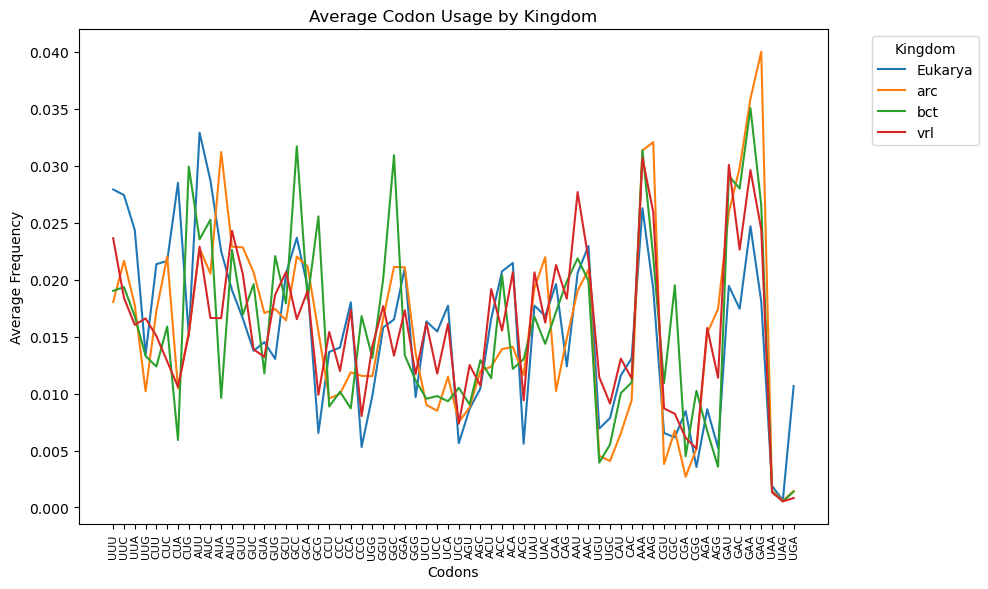

In [34]:
# Group by Kingdom and calculate mean codon usage across numeric columns
grouped_df = df.groupby('Kingdom').mean(numeric_only=True)


# Plot the mean codon usage by Kingdom
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize for better visibility
grouped_df.T.plot(ax=ax, legend=True)
ax.set_title('Average Codon Usage by Kingdom')
ax.set_xlabel('Codons')
ax.set_ylabel('Average Frequency')

# Display all x-axis labels
ax.set_xticks(range(len(grouped_df.columns)))
ax.set_xticklabels(grouped_df.columns, rotation=90, fontsize=8)

# Move legend outside the plot
ax.legend(title='Kingdom', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [36]:
# Remove rows with NaN values in the 'Kingdom' column
df = df.dropna(subset=['Kingdom'])

# Verify that NaN values are removed
print(df['Kingdom'].isna().sum())

0


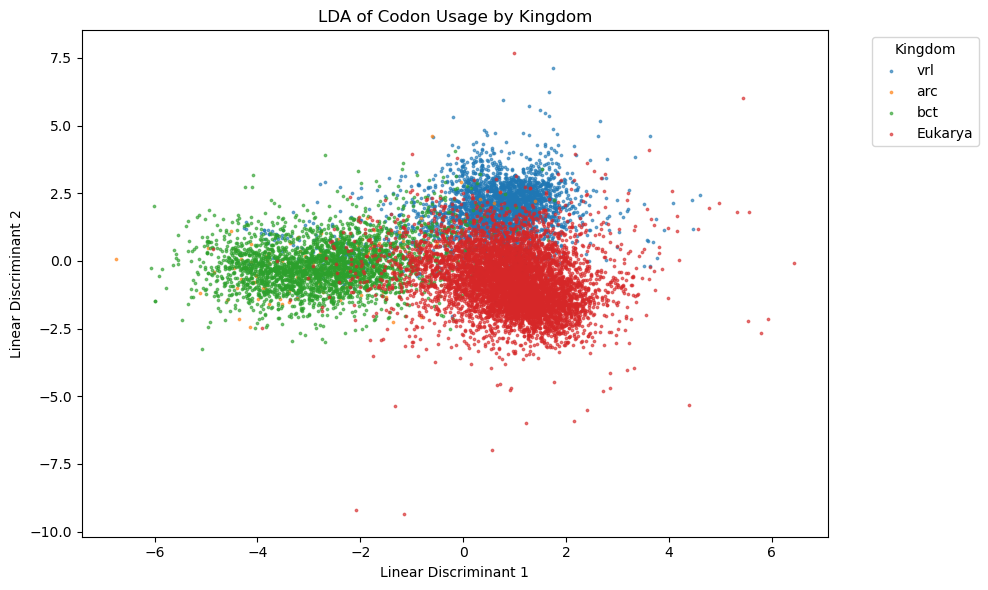

In [44]:
# Extract features and target labels
X = df.drop(columns=['Kingdom'], errors='ignore')
y = df['Kingdom']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=2)  # Reduce to 2 linear discriminants
X_lda = lda.fit_transform(X_scaled, y)

# Create a DataFrame for LDA results
lda_df = pd.DataFrame(
    X_lda,
    columns=['LD1', 'LD2']
)
lda_df['Kingdom'] = y

# Remove rows with NaN values in the 'Kingdom' column
lda_df = lda_df.dropna(subset=['Kingdom'])

# Plot the LDA results
fig, ax = plt.subplots(figsize=(10, 6))
kingdoms = lda_df['Kingdom'].unique()

for kingdom in kingdoms:
    subset = lda_df[lda_df['Kingdom'] == kingdom]
    ax.scatter(
        subset['LD1'],
        subset['LD2'],
        label=kingdom,
        s=3, alpha=0.6
    )

# Add plot title and labels
ax.set_title('LDA of Codon Usage by Kingdom')
ax.set_xlabel('Linear Discriminant 1')
ax.set_ylabel('Linear Discriminant 2')

# Add legend
ax.legend(title='Kingdom', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Perform Min Max scaling

In [50]:
columns_to_scale = df.columns[1:]
print(columns_to_scale) 
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df

Index(['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC',
       'AUA', 'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG',
       'CCU', 'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU',
       'UCC', 'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU',
       'UAC', 'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA',
       'AAG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA',
       'GAG', 'UAA', 'UAG', 'UGA'],
      dtype='object')


,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0.076116,0.131203,0.003304,0.034687,0.133994,0.319681,0.006101,0.373475,0.035765,...,0.081203,0.131843,0.609105,0.054023,0.405130,0.083029,0.275055,0.055531,0.019524,0.000000
1,vrl,0.124896,0.147999,0.004493,0.067003,0.045333,0.283906,0.012445,0.410729,0.074841,...,0.024487,0.171608,0.615437,0.065765,0.399245,0.107668,0.278146,0.059956,0.026552,0.000000
2,vrl,0.090842,0.237758,0.089672,0.152485,0.087102,0.110713,0.062714,0.111111,0.148189,...,0.107310,0.199737,0.425980,0.168372,0.178848,0.154738,0.155661,0.086504,0.000000,0.013496
3,vrl,0.081684,0.244847,0.106985,0.098033,0.174538,0.135326,0.057345,0.160473,0.155913,...,0.065898,0.142669,0.285983,0.202521,0.169712,0.209055,0.217345,0.057743,0.061304,0.000000
4,vrl,0.129590,0.149526,0.050684,0.363573,0.153709,0.054609,0.028856,0.193350,0.176295,...,0.108750,0.151169,0.296765,0.223419,0.218113,0.231831,0.232040,0.000000,0.017181,0.012277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,Eukarya,0.117441,0.387719,0.036146,0.135092,0.142125,0.208969,0.050024,0.331098,0.094703,...,0.147641,0.138318,0.187233,0.073629,0.200193,0.138381,0.258720,0.020133,0.035533,0.059794
13024,Eukarya,0.057892,0.348239,0.131104,0.062160,0.161617,0.530344,0.466325,0.117165,0.200961,...,0.026107,0.000000,0.008215,0.010449,0.114722,0.126855,0.042699,0.053540,0.037876,0.176851
13025,Eukarya,0.065486,0.362199,0.109760,0.035181,0.125529,0.502441,0.586201,0.099469,0.177074,...,0.000000,0.000000,0.000000,0.009587,0.145907,0.192422,0.018732,0.078761,0.046466,0.189035
13026,Eukarya,0.080856,0.221180,0.050684,0.127779,0.146915,0.195217,0.043619,0.369191,0.103856,...,0.205618,0.123141,0.204689,0.117311,0.220485,0.199876,0.249700,0.021903,0.030847,0.014620


In [49]:
max(df["UUU"])

1.0

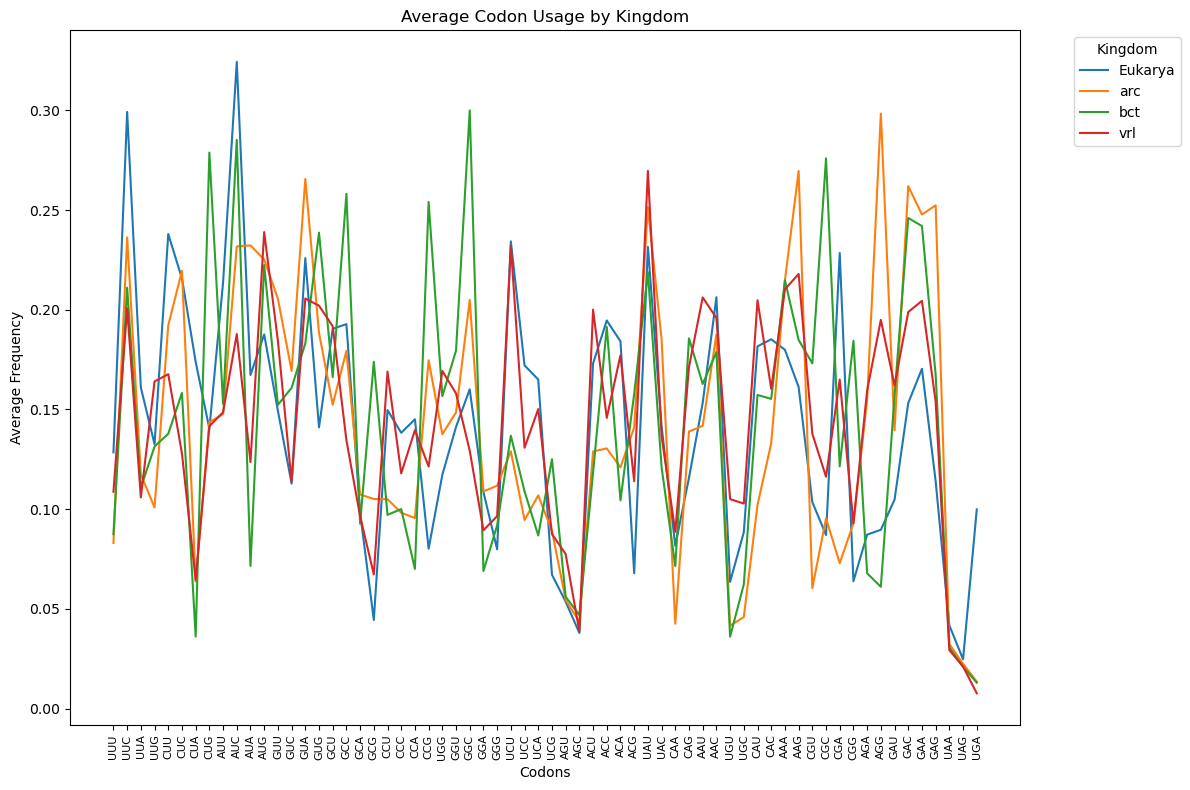

In [53]:
columns_to_scale = df.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Group by 'Kingdom' and calculate mean codon usage across numeric columns
grouped_df = df.groupby('Kingdom').mean()

# Plot the mean codon usage by Kingdom
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figsize for better visibility
grouped_df.T.plot(ax=ax, legend=True)

# Set plot title and axis labels
ax.set_title('Average Codon Usage by Kingdom')
ax.set_xlabel('Codons')
ax.set_ylabel('Average Frequency')

# Display all x-axis labels
ax.set_xticks(range(len(grouped_df.T.index)))
ax.set_xticklabels(grouped_df.T.index, rotation=90, fontsize=8)

# Move legend outside the plot
ax.legend(title='Kingdom', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for readability
plt.tight_layout()
plt.show()

visualize again

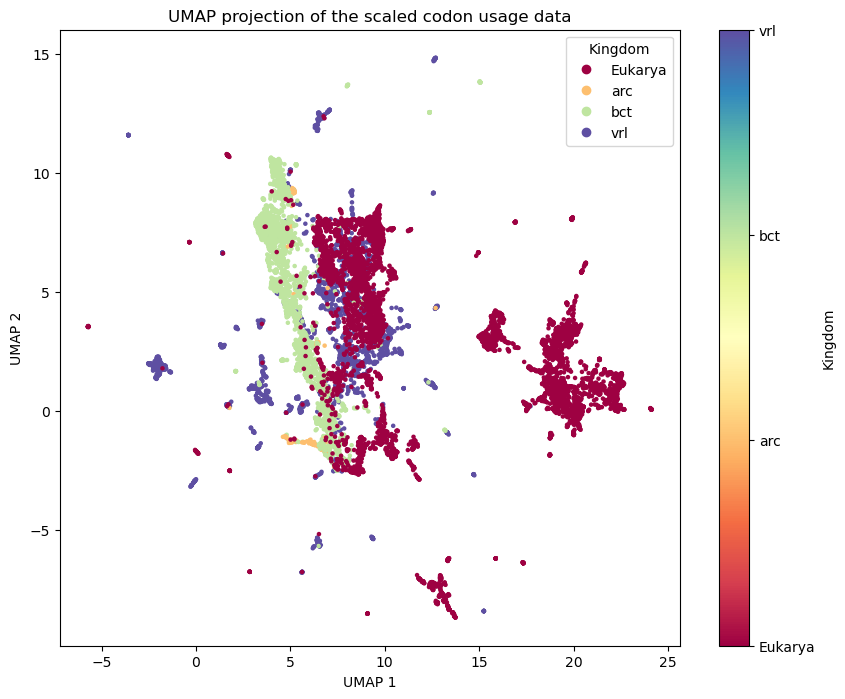

In [54]:
features = df.drop('Kingdom', axis=1)
features = features.apply(pd.to_numeric, errors='coerce')
features = features.dropna()

# Align labels with the filtered features
labels = df['Kingdom'].loc[features.index]

# Convert labels to a categorical type
labels = labels.astype('category')

# Fit and transform the data using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(features)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels.cat.codes.to_numpy(),  # Convert categories to numeric codes
    cmap='Spectral',
    s=5
)

# Add colorbar with categories
colorbar = plt.colorbar(scatter, ticks=range(len(labels.cat.categories)))
colorbar.ax.set_yticklabels(labels.cat.categories)
colorbar.set_label('Kingdom')

plt.title('UMAP projection of the scaled codon usage data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create a legend
handles, _ = scatter.legend_elements()
plt.legend(handles, labels.cat.categories, title="Kingdom")

plt.show()

### **Class Distribution Analysis**

The number of samples per kingdom is visualized to highlight dataset imbalance. The `arc` Kingdom contains only a small amount of entries (126), while the others are in the hundreds or thousands. Addressing this imbalance is critical for building a fair and robust classifier.

### Class Distributions 

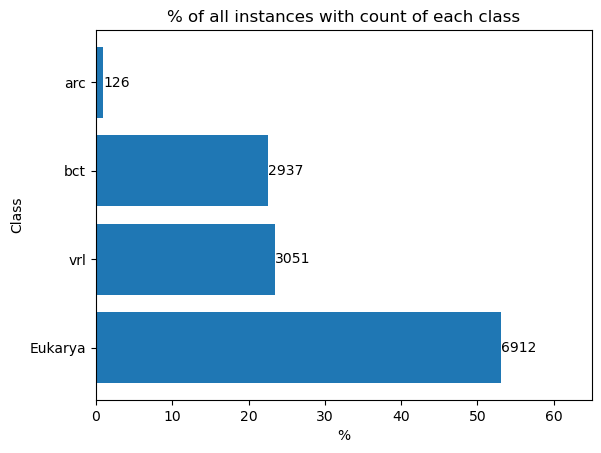

In [55]:
temp = df["Kingdom"].value_counts()
percentages = temp / len(df["Kingdom"]) * 100

plt.barh(temp.index, percentages.values)
plt.title('% of all instances with count of each class')
plt.xlabel('%')
plt.ylabel('Class')
plt.xlim(0, 65)

# Add text annotations at the end of the bars
for index, value in enumerate(percentages.values):
    count = temp.values[index]
    plt.text(value, index, f'{count}', va='center', ha='left')

plt.show()


### Model Evaluation
This section contains the function for the evaluation of the models. It's in an own section to avoid repetitive code.

In [ ]:
def evaluate_model(clf, X_test, y_test, label_encoder, feature_names, top_n_features=10):
    """
    Evaluate the performance of a trained model and visualize key metrics.

    Parameters:
    - clf: Trained classifier
    - X_test: Test features
    - y_test: Test target labels
    - label_encoder: LabelEncoder instance to decode target labels
    - feature_names: List of feature names
    - top_n_features: Number of top features to visualize by importance
    """
    # 1. Predictions and Metrics
    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # 2. Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=label_encoder.classes_,
        cmap='Blues'
    )
    plt.title('Confusion Matrix')
    plt.show()

    # 3. Feature Importance
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        # Plot Top N Important Features
        feature_importance_df.head(top_n_features).plot(
            kind='bar', x='Feature', y='Importance', figsize=(6, 4)
        )
        plt.title(f'Top {top_n_features} Important Features')
        plt.show()
    else:
        print("The provided classifier does not support feature importance.")

### **Model Training: Random Forest with Class Weights**

A **Random Forest Classifier** is used to classify kingdoms based on codon usage. Key details:

- **Class Weight Adjustment:** Underrepresented classes are given higher weights to ensure balanced learning.
- **Random Forest Benefits:** Handles high-dimensional data, reduces overfitting, and captures complex relationships in the data.
- **Model Parameters:** Class weights, number of estimators, and tree depth are configured for optimal performance.

This section establishes the baseline model while addressing the class imbalance issue.


Train Class Distribution:
 0    0.530614
3    0.234261
2    0.225432
1    0.009693
Name: proportion, dtype: float64
Test Class Distribution:
 0    0.530698
3    0.234075
2    0.225633
1    0.009593
Name: proportion, dtype: float64
Class Weights: {np.int64(0): np.float64(0.4711521070718032), np.int64(1): np.float64(25.792079207920793), np.int64(2): np.float64(1.108982545764155), np.int64(3): np.float64(1.0671855796804588)}
Accuracy: 0.9339984650805833
              precision    recall  f1-score   support

     Eukarya       0.93      0.97      0.95      1383
         arc       0.93      0.56      0.70        25
         bct       0.94      0.92      0.93       588
         vrl       0.93      0.88      0.90       610

    accuracy                           0.93      2606
   macro avg       0.93      0.83      0.87      2606
weighted avg       0.93      0.93      0.93      2606



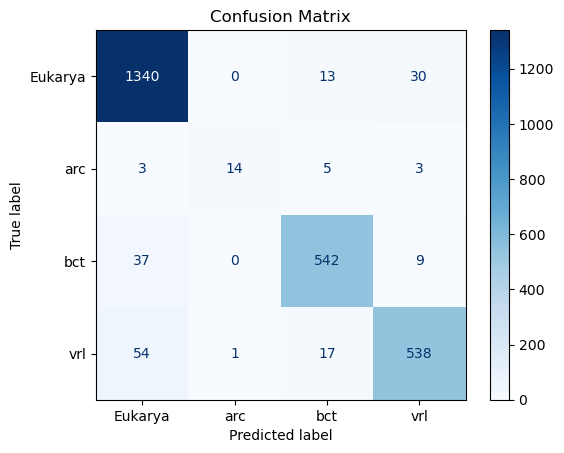

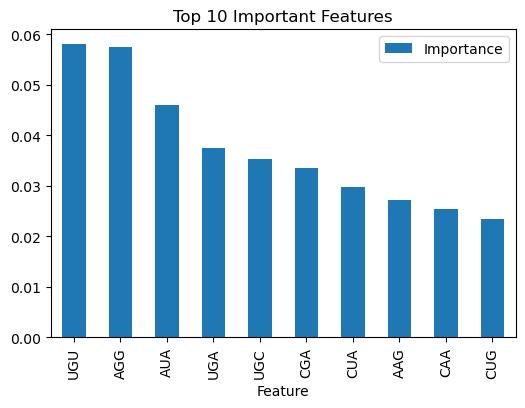

In [57]:
# Separate features and target
X = df.drop(columns=['Kingdom'])
y = df['Kingdom']


# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Check class distribution after split
train_distribution = pd.Series(y_train).value_counts(normalize=True)
test_distribution = pd.Series(y_test).value_counts(normalize=True)
print("Train Class Distribution:\n", train_distribution)
print("Test Class Distribution:\n", test_distribution)

# Compute Class Weights
class_weights = dict(
    zip(
        np.unique(y_train),
        compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    )
)
print("Class Weights:", class_weights)

# Train Random Forest Classifier with Class Weights
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

evaluate_model(
    clf=clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns,
    top_n_features=10
)

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best model
best_clf = grid_search.best_estimator_

# Evaluate the tuned model using the evaluate_model function
evaluate_model(
    clf=best_clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns,
    top_n_features=10
)

### **Manual Oversampling for Minority Classes**

To address the severe class imbalance, the minority class (`arc`) is manually oversampled. Key reasons:

- **Limited Samples:** `arc` has very few samples, which hampers model learning.
- **Avoid Synthetic Data:** Instead of SMOTE, actual samples are duplicated to improve representation.
- **Stratified Train-Test Split:** Ensures fair representation across training and testing datasets.

This approach enhances the model's ability to identify patterns in the minority class without introducing synthetic bias.


Accuracy: 0.9434250764525994
              precision    recall  f1-score   support

     Eukarya       0.96      0.96      0.96      1383
         arc       0.97      0.86      0.91        35
         bct       0.94      0.93      0.93       588
         vrl       0.91      0.92      0.92       610

    accuracy                           0.94      2616
   macro avg       0.94      0.92      0.93      2616
weighted avg       0.94      0.94      0.94      2616



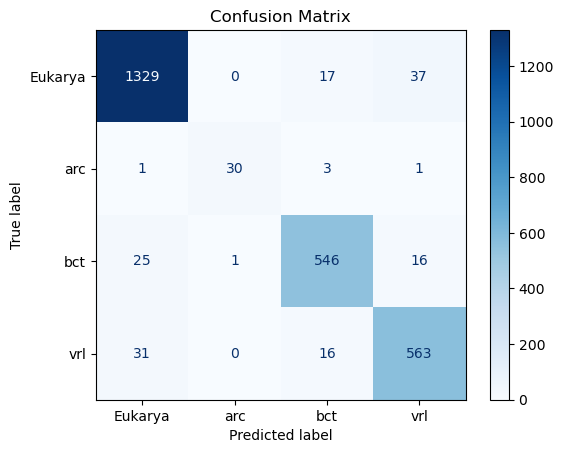

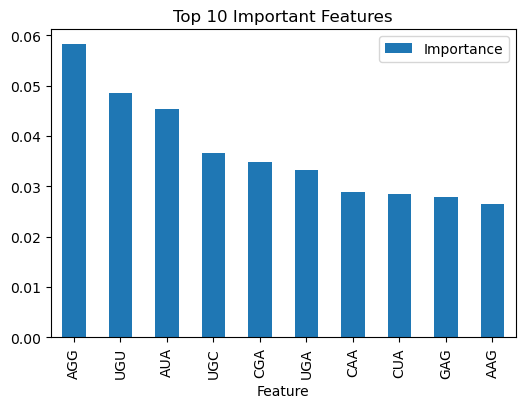

In [60]:
# Manual Oversampling for 'arc'
arc_samples = df[df['Kingdom'] == 'arc']
df_oversampled = pd.concat([df, arc_samples.sample(n=50, replace=True, random_state=42)])

# Recreate Train-Test Split
X = df_oversampled.drop(columns=['Kingdom'])
y = df_oversampled['Kingdom']



X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Retrain with the Tuned Hyperparameters
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_leaf=2,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

evaluate_model(
    clf=clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns,
    top_n_features=10
)

In [61]:
# Apply SMOTE only on the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Class distribution after SMOTE on training set:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution after SMOTE on training set:
Kingdom
Eukarya    5529
vrl        5529
bct        5529
arc        5529
Name: count, dtype: int64



Baseline Model Evaluation:
Accuracy: 0.9457186544342507
              precision    recall  f1-score   support

     Eukarya       0.95      0.97      0.96      1383
         arc       0.96      0.77      0.86        35
         bct       0.94      0.92      0.93       588
         vrl       0.93      0.92      0.92       610

    accuracy                           0.95      2616
   macro avg       0.95      0.90      0.92      2616
weighted avg       0.95      0.95      0.95      2616



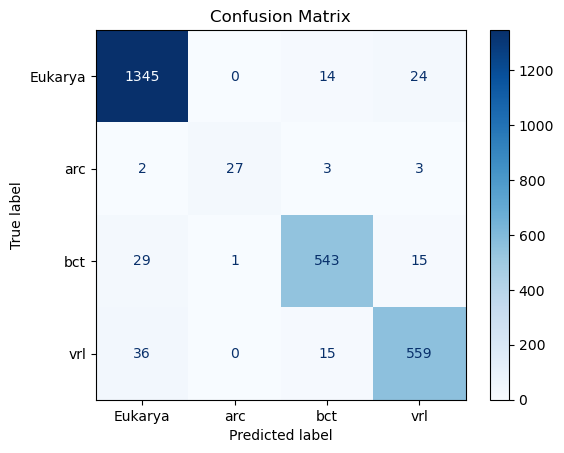

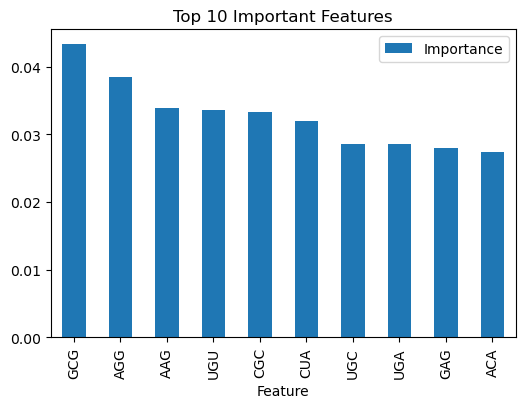

In [62]:
# Train a Baseline Random Forest Model
rf_clf_baseline = RandomForestClassifier(random_state=42)  # Default parameters
rf_clf_baseline.fit(X_train, y_train)

# Evaluate the Baseline Model
print("\nBaseline Model Evaluation:")
evaluate_model(
    clf=rf_clf_baseline,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)

### **Hyperparameter Optimization**

Hyperparameters of the Random Forest Classifier are fine-tuned using **GridSearchCV**. Key parameters include:

- **`n_estimators`:** Number of trees in the forest.
- **`max_depth`:** Maximum tree depth to prevent overfitting.
- **`min_samples_split`:** Minimum samples required to split a node.
- **`min_samples_leaf`:** Minimum samples required at leaf nodes.

The objective is to identify the configuration that maximizes performance while maintaining generalizability.


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Perform GridSearchCV for Hyperparameter Optimization
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

print("\nStarting GridSearchCV...")
grid_search.fit(X_train, y_train)

# Retrieve Best Model and Parameters
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score (Weighted):", grid_search.best_score_)

# Evaluate the Best Model
best_rf_clf = grid_search.best_estimator_
print("\nBest Model Evaluation:")
evaluate_model(
    clf=best_rf_clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)


### **Best Model Parameters**
After hyperparameter tuning, the best-performing model configuration is presented. These parameters balance accuracy and computational efficiency.

`{'class_weight': 'balanced',`
` 'max_depth': 30,`
 `'min_samples_leaf': 2,`
 `'min_samples_split': 5,`
 `'n_estimators': 300}`



Final Model Evaluation:
Accuracy: 0.9468654434250765
              precision    recall  f1-score   support

     Eukarya       0.97      0.95      0.96      1383
         arc       0.92      0.94      0.93        35
         bct       0.94      0.94      0.94       588
         vrl       0.90      0.95      0.92       610

    accuracy                           0.95      2616
   macro avg       0.93      0.95      0.94      2616
weighted avg       0.95      0.95      0.95      2616



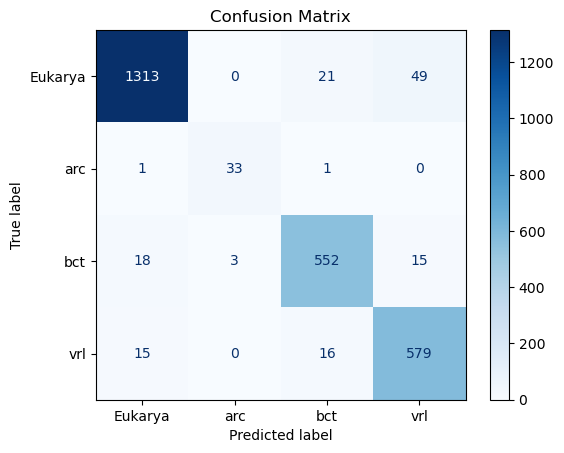

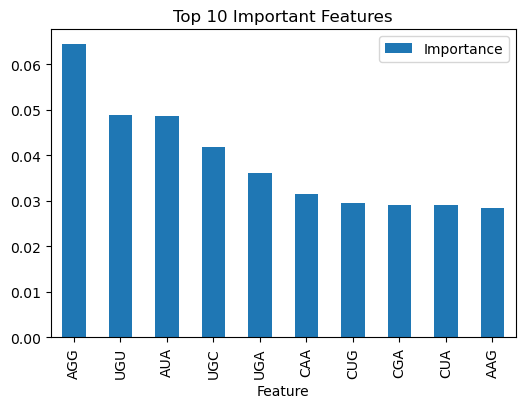

In [64]:
# Train the final model with best parameters
final_rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)

# Fit the final model on resampled training data
final_rf_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
print("\nFinal Model Evaluation:")
evaluate_model(
    clf=final_rf_clf,
    X_test=X_test,  # Use the scaled test data
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns  # Match the original feature names
)


Initial SVM Model Evaluation:
Accuracy: 0.9602446483180428
              precision    recall  f1-score   support

     Eukarya       0.99      0.96      0.97      1383
         arc       0.89      0.94      0.92        35
         bct       0.97      0.95      0.96       588
         vrl       0.90      0.98      0.94       610

    accuracy                           0.96      2616
   macro avg       0.94      0.96      0.95      2616
weighted avg       0.96      0.96      0.96      2616



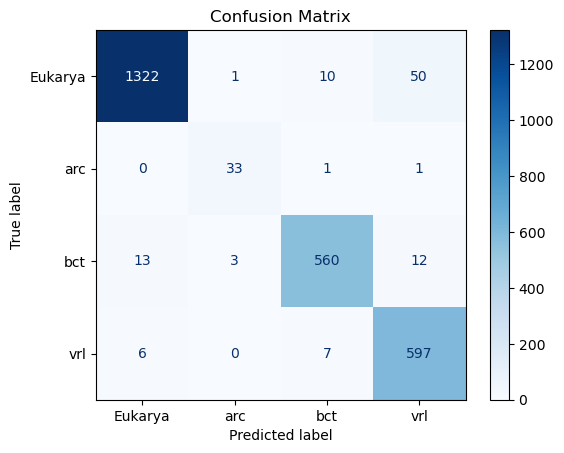

The provided classifier does not support feature importance.


In [65]:
svm_clf = SVC(random_state=42)  # Default parameters
svm_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate Initial SVM Model
print("\nInitial SVM Model Evaluation:")
evaluate_model(
    clf=svm_clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)

In [ ]:
# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Perform GridSearchCV for Hyperparameter Optimization
grid_search_svm = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

print("\nStarting GridSearchCV for SVM...")
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# Retrieve Best Parameters
print("\nBest Parameters:", grid_search_svm.best_params_)
print("Best F1 Score (Weighted):", grid_search_svm.best_score_)

# Evaluate the Best SVM Model
best_svm_clf = grid_search_svm.best_estimator_
print("\nBest SVM Model Evaluation:")
evaluate_model(
    clf=best_svm_clf,
    X_test=X_test,
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)



Final SVM Model Evaluation:
Accuracy: 0.9648318042813455
              precision    recall  f1-score   support

     Eukarya       0.98      0.98      0.98      1383
         arc       0.97      0.89      0.93        35
         bct       0.96      0.93      0.95       588
         vrl       0.94      0.96      0.95       610

    accuracy                           0.96      2616
   macro avg       0.96      0.94      0.95      2616
weighted avg       0.96      0.96      0.96      2616



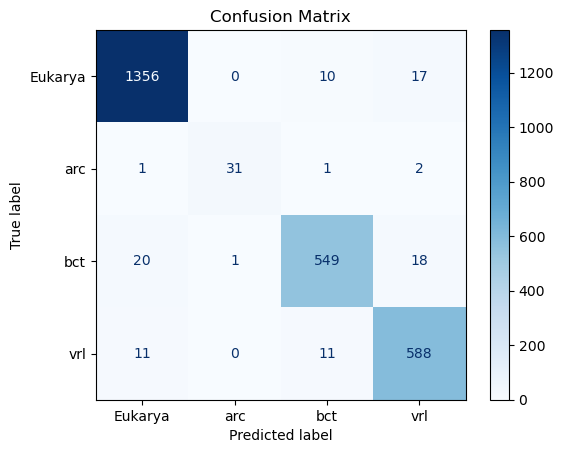

The provided classifier does not support feature importance.


In [66]:
# Train the final SVM model with best parameters
final_svm_clf = SVC(
    C=100,
    gamma='scale',
    kernel='rbf',
    random_state=42
)

# Fit the final model on resampled training data
final_svm_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
print("\nFinal SVM Model Evaluation:")
evaluate_model(
    clf=final_svm_clf,
    X_test=X_test,  # Use the scaled test data
    y_test=y_test,
    label_encoder=label_encoder,
    feature_names=X.columns
)


There are strong imbalences between calsses
to rectify this problem we performed SMOTE

### Creating a XGBoost Classifier and parameter optimization with BayesSearch

In [13]:
opt = BayesSearchCV(
    XGBClassifier(),
    {
    'max_depth': (3, 18),  # integer valued parameter
    'learning_rate': (1e-4, 0.3, 'log-uniform'),  # log-uniform: vary learning rate exponentially
    'n_estimators': (50, 500),  # integer valued parameter
    'gamma': (1e-6, 9, 'log-uniform'),  # log-uniform: vary gamma exponentially
    'min_child_weight': (0, 10),  # integer valued parameter
    'subsample': (0.5, 1.0),  # uniform distribution
    'colsample_bytree': (0.5, 1.0),  # uniform distribution
    'reg_alpha': (1e-6, 10, 'log-uniform'),  # L1 regularization
    'reg_lambda': (1e-6, 10, 'log-uniform'),  # L2 regularization
    },
    n_iter=25,
    cv=5
)

start = time()

opt.fit(X_train_resampled, y_train_resampled)
print("time:", time() - start)
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("Optimal parameters: %s" % opt.best_params_)

time: 3277.978072166443
val. score: 0.9788061501790493
test score: 1.0
Optimal parameters: OrderedDict({'colsample_bytree': 0.5, 'gamma': 1e-06, 'learning_rate': 0.3, 'max_depth': 18, 'min_child_weight': 5, 'n_estimators': 128, 'reg_alpha': 1e-06, 'reg_lambda': 1e-06, 'subsample': 0.5})


Run Model with best parameters

In [72]:
best_params = {
    'colsample_bytree': 0.8857781478235609,
    'gamma': 5.829498728872856e-06,
    'learning_rate': 0.2772019263304506,
    'max_depth': 14,
    'min_child_weight': 3,
    'n_estimators': 177,
    'reg_alpha': 0.10465113394009344,
    'reg_lambda': 8.831902263633859,
    'subsample': 0.7851661145758986
}
label_encoder = LabelEncoder()
y_train_resampled_encoded = label_encoder.fit_transform(y_train_resampled)
y_test = label_encoder.fit_transform(y_test)

# Verify encoding
print("Classes:", label_encoder.classes_)

# Create the XGBClassifier with the specified parameters
model = XGBClassifier(**best_params)

n_splits = 5  # Number of folds
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model, X_train_resampled, y_train_resampled_encoded, cv=stratified_kfold, scoring='accuracy')

# Display the scores
print(f"Accuracy scores for each fold: {scores}")
print(f"Mean accuracy: {np.mean(scores):.4f}")
print(f"Standard deviation of accuracy: {np.std(scores):.4f}")

Classes: ['Eukarya' 'arc' 'bct' 'vrl']
Accuracy scores for each fold: [0.98688969 0.98643455 0.98281709 0.98530409 0.98553018]
Mean accuracy: 0.9854
Standard deviation of accuracy: 0.0014


In [73]:
model.fit(X_train_resampled, y_train_resampled_encoded)
y_pred = model.predict(X_test)
print(f"Accuracy Score optimized Model : {accuracy_score(y_test, y_pred)}")

Accuracy Score optimized Model : 0.963302752293578


Display Confusion Matrix to see if any classes are mislabeld disproportionately

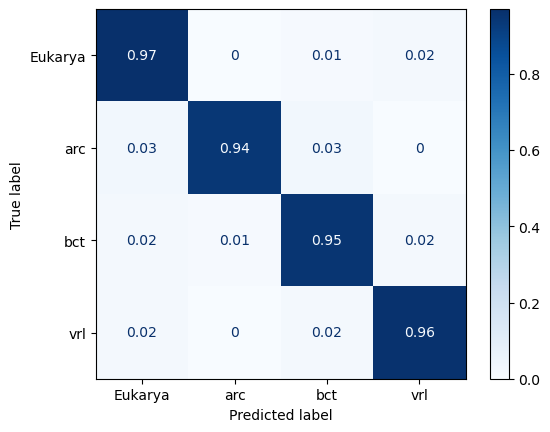

In [74]:
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.around(cm_normalized, decimals=2)

# Display the normalized and rounded confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()

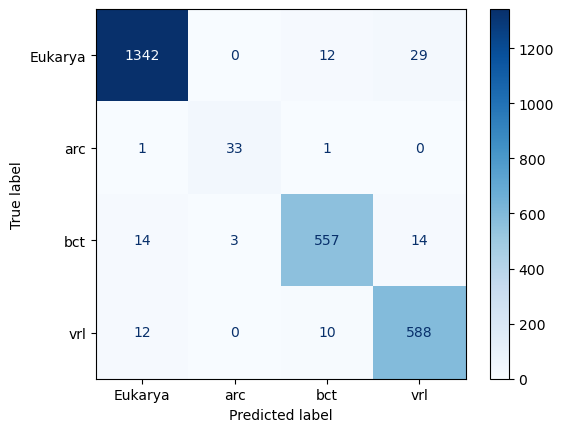

In [75]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LabelEncoder().fit(df['Kingdom']).classes_)
disp.plot(cmap='Blues')
plt.show()

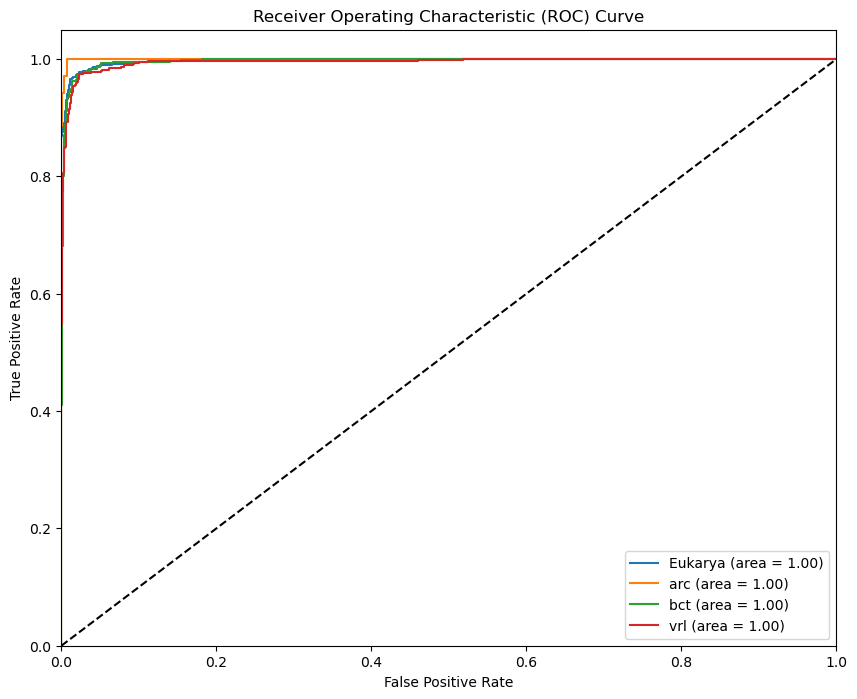

In [76]:
# Binarize the output labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
y_pred_proba = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])


# Get the class names from the label encoder
class_names = LabelEncoder().fit(df['Kingdom']).classes_

# Plot ROC curve for each class with class names
plt.figure(figsize=(10, 8))
for i in range(y_test_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **Evaluation of Using ChatGPT for the Assignment**

### **Interface/Version of ChatGPT Tried**
For this project, we used **ChatGPT-4 via the website interface**. The tool provided quick responses and maintained context effectively across a long session, which was useful for iterative problem-solving.
- **Pros:**
  - Responses were well-structured, making it easy to integrate into the workflow.
  - Effective at combining high-level explanations with detailed code implementations when needed.
- **Cons:**
  - Occasionally verbose and required filtering to identify the most relevant parts.
  - Some repetitive responses, especially for previously clarified points.

### **Effective and Ineffective Prompts**
- **Prompts That Worked Well:**
  - Precise, task-oriented prompts like "Implement SVM with SMOTE and hyperparameter optimization" delivered complete, actionable code with minimal need for modification.
  - Requests for conceptual comparisons, e.g., "When to use GridSearchCV vs. Bayesian Optimization," yielded concise and accurate distinctions.
- **Prompts That Did Not Work Well:**
  - Overly broad or vague prompts like "What is the best optimization method?" led to generalized answers that required follow-ups to refine.
  - Asking for simplified workflows sometimes resulted in oversimplification, requiring iterative clarifications.

### **Workflows Tried and Recommendations**
- **Workflows Tried:**
  - I frequently began with high-level conceptual questions to outline a solution, followed by targeted prompts for specific implementations. For example, I asked for a pipeline integrating SMOTE and Random Forest, then refined it step-by-step.
  - I used ChatGPT for debugging when encountering errors, providing detailed error messages and relevant code snippets. This was especially useful for correcting issues like data leakage in train-test splits.
- **Recommendation:**
  - ChatGPT works best with a structured workflow: Begin with specific objectives, verify outputs iteratively, and cross-check results to ensure correctness.

### **Ensuring Code Correctness**
I ensured code correctness through multiple methods:
1. Cross-validated outputs against expected results. For example, after applying SMOTE, I checked class distributions and verified model performance on unseen test data.
2. Tested implementations in my local environment to confirm compatibility and correctness, adjusting minor details like variable mismatches or function arguments.
3. Applied metrics (e.g., accuracy, F1-score) and confusion matrices to verify that model behavior matched theoretical expectations.

### **General Impression of Usefulness/Problems**
- **Usefulness:**
  - ChatGPT was a valuable assistant, particularly for implementing standard techniques like SMOTE, hyperparameter optimization, and ensemble methods. It saved significant time by providing ready-to-run code and enabling iterative refinement of solutions.
  - Its ability to explain concepts like the differences between GridSearchCV and RandomizedSearchCV reinforced my understanding of when to use specific techniques.
- **Problems:**
  - While the tool’s outputs were generally accurate, verbose responses occasionally slowed the process by requiring manual filtering of the most relevant information.
  - In cases of ambiguous prompts, responses were overly generic, requiring me to rephrase for clarity.

### **Final Thoughts**
Overall, ChatGPT significantly enhanced the efficiency of solving this assignment. It allowed us to focus on critical aspects of the workflow, like model evaluation and result interpretation, by streamlining coding and debugging tasks. Its performance aligns well with tasks requiring rapid prototyping and iterative improvements. While it’s not without limitations—like verbosity or handling vague prompts—it is a powerful tool for complementing domain knowledge and enhancing productivity.
